# Evaluation of off-the-shelf coreference models

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt

## Preparation

First we read our test data. 

In [3]:
sys.path.append(r'../')

In [4]:
from quillnlp.utils import extract_referents_from_xml_tagged_strings

In [5]:
DATA_DIR = Path("../data")
COREF_TEST_DATA = DATA_DIR / "validated/pronom_coref_res/junkfood_coref_gold.tsv"

texts = []
with open(COREF_TEST_DATA) as i:
    for line in i:
        line = line.strip().split("\t")
        text = " ".join(line)
        texts.append(text)
        
data = list(extract_referents_from_xml_tagged_strings(texts))

[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 72, 'end': 93, 'str_': 'more nutritious foods', 'id': '2'}, {'start': 102, 'end': 106, 'str_': 'they', 'id': '2'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 62, 'str_': 'it', 'id': '1'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 60, 'end': 64, 'str_': 'they', 'id': '0'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 66, 'str_': 'it', 'id': '1'}, {'start': 78, 'end': 83, 'str_': 'their', 'id': '2'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id': '0'}, {'start': 25, 'end': 34, 'str_': 'junk food', 'id': '1'}, {'start': 64, 'end': 68, 'str_': 'they', 'id': '0'}]
[{'start': 0, 'end': 7, 'str_': 'Schools', 'id':

In [6]:
context = "Students love junk food."
texts_with_context = [context + " " + text for text in texts]
data_with_context = list(extract_referents_from_xml_tagged_strings(texts_with_context))

data_with_context[:3]

[{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'}, {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'}, {'start': 97, 'end': 118, 'str_': 'more nutritious foods', 'id': '2'}, {'start': 127, 'end': 131, 'str_': 'they', 'id': '2'}]
[{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'}, {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'}, {'start': 85, 'end': 87, 'str_': 'it', 'id': '1'}]
[{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'}, {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'}, {'start': 85, 'end': 89, 'str_': 'they', 'id': '0'}]
[{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'}, {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'}, {'start': 89, 'end': 91, 'str_': 'it', 'id': '1'}, {'start': 103, 'end': 108, 'str_': 'their', 'id': '2'}]
[{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'}, {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'}, {'start': 89, 'end': 93, 'str_': 'they', 'id': '0'}]
[{'start': 25, 'end': 32, 'str_': '

[{'text': 'Students love junk food. Schools should not allow junk food to be sold on campus but should sell more nutritious foods because they have great nutritional value',
  'refs': [{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'},
   {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'},
   {'start': 97, 'end': 118, 'str_': 'more nutritious foods', 'id': '2'},
   {'start': 127, 'end': 131, 'str_': 'they', 'id': '2'}]},
 {'text': 'Students love junk food. Schools should not allow junk food to be sold on campus but it generates money for schools',
  'refs': [{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'},
   {'start': 50, 'end': 59, 'str_': 'junk food', 'id': '1'},
   {'start': 85, 'end': 87, 'str_': 'it', 'id': '1'}]},
 {'text': 'Students love junk food. Schools should not allow junk food to be sold on campus but they should have greater accessibility to nutrient dense foods',
  'refs': [{'start': 25, 'end': 32, 'str_': 'Schools', 'id': '0'},
   {'start': 50, 'end':

Then we load spaCy's English pipeline and add Huggingface's Neuralcoref pipe to it.

In [7]:
import spacy
import neuralcoref

nlp = spacy.load("en")
neuralcoref.add_to_pipe(nlp)

Finally, we load AllenNLP's coreference predictor.

In [8]:
from allennlp.predictors.predictor import Predictor

predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/coref-model-2018.02.05.tar.gz")

/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


## Evaluation methods

In [9]:
from collections import defaultdict
from copy import deepcopy

def evaluate_links(predicted_links, gold_links):
    """ 
    Evaluates a set of predicted co-reference links against 
    a set of gold co-reference links. 
    """
    tp, fp, fn = 0, 0, 0
    for link in predicted_links:
        if link in gold_links:
            tp += 1
        else:
            fp += 1
    
    for link in gold_links:
        if link not in predicted_links:
            fn += 1
            
    return (tp, fp, fn)


def transform_coref_clusters_to_links(data_item):
    """
    Transforms a data item and transforms its coreference clusters
    to a list of coreference links.  
    """
    gold_clusters = defaultdict(list)
    for ref in data_item["refs"]:
        gold_clusters[ref["id"]].append((ref["start"], ref["str_"]))

    gold_links = []
    for c_id, c_words in gold_clusters.items():
        if len(c_words) > 1:     
            c_words.sort()
            antecedent = c_words[0]
            for other_word in c_words[1:]:
                gold_links.append((antecedent[0], other_word[0]))
    return gold_links


def get_coref_links_from_spacy_doc(doc):
    """
    Takes a spaCy doc on which co-reference has been performed with 
    Huggingface's Neuralcoref system, and gets the coreference links
    from this document.
    """
    predicted_links = []
    print("NeuralCoref output:", doc._.coref_clusters)
    for c in doc._.coref_clusters:
        antecedent = c[0]
        for other_word in c[1:]:
            predicted_links.append((antecedent.start_char, other_word.start_char))
    return predicted_links
            

def get_coref_links_from_allennlp(text, prediction):
    """
    Takes a text and the corresponding output of the AllenNLP 
    coreference model, and gets the coreference links from this input.
    Tokenization is performed with spaCy. This is AllenNLP's standard
    solution and is also Neuralcoref's tokenization method.
    """
    predicted_links = []
    spacy_doc = nlp(text)
    print("AllenNLP Output:", prediction["clusters"])
    for c in prediction["clusters"]:
        antecedent_token_idx = c[0][0]
        for other_word in c[1:]:
            antecedent_char_idx = spacy_doc[antecedent_token_idx].idx
            other_word_token_idx = other_word[0]
            other_word_char_idx = spacy_doc[other_word_token_idx].idx
            predicted_links.append((antecedent_char_idx, other_word_char_idx))
    
    return predicted_links
    

def evaluate_coref(data, model):
    """
    Perform a full evaluation round on our test data.
    Model is either "neuralcoref" or "allennlp".
    """
    tp, fp, fn = 0, 0, 0
    for data_item in data:
        
        if not data_item["text"].endswith("."):
            data_item["text"] += "."
        
        gold_links = transform_coref_clusters_to_links(data_item)
        
        if model == "neuralcoref":
            doc = nlp(data_item["text"])
            predicted_links = get_coref_links_from_spacy_doc(doc)    
        
        elif model == "allennlp":
            prediction = predictor.predict(document=data_item["text"])
            predicted_links = get_coref_links_from_allennlp(data_item["text"], prediction)
            
        else:
            return ValueError(f"Unknown model: {model}")
                    
        print("Predicted links:", predicted_links)
        print("Gold links", gold_links)
        print("\n")

        tp_, fp_, fn_ = evaluate_links(predicted_links, gold_links)

        tp += tp_
        fp += fp_
        fn += fn_

    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f = 2*p*r/(p+r) if p+r > 0 else 0

    print("Precision:", p)
    print("Recall:", r)
    print("F1 score:", f)
    return p, r, f
    

## Evaluation Neuralcoref

In [10]:
p_neuralcoref, r_neuralcoref, f_neuralcoref = evaluate_coref(data, model="neuralcoref")

NeuralCoref output: [more nutritious foods: [more nutritious foods, they]]
Predicted links: [(72, 102)]
Gold links [(72, 102)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0, 60)]
Gold links [(25, 60)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: [Schools: [Schools, their]]
Predicted links: [(0, 78)]
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 64)]
Gold links [(0, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 64)]
Gold links [(0, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold li

NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [many people: [many people, they]]
Predicted links: [(60, 145)]
Gold links [(25, 82), (123, 145)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0, 64)]
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60), (25, 107)]


NeuralCoref output: [Schools: [Schools, them]]
Predicted links: [(0, 83)]
Gold links [(25, 83)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Pr

NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0, 60)]
Gold links [(25, 60)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: [parents: [parents, they, their]]
Predicted links: [(60, 103), (60, 116)]
Gold links [(60, 103), (60, 116)]


NeuralCoref output: []
Predicted links: []
Gold links [(25, 64)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(0, 64)]
Gold links [(25, 64)]


NeuralCoref output: []
Predicted links: []
Gold links [(114

In [11]:
p_neuralcoref_context, r_neuralcoref_context, f_neuralcoref_context = evaluate_coref(data_with_context, 
                                                                                     model="neuralcoref")

NeuralCoref output: [more nutritious foods: [more nutritious foods, they]]
Predicted links: [(97, 127)]
Gold links [(97, 127)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(25, 85)]
Gold links [(50, 85)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


NeuralCoref output: [Schools: [Schools, their]]
Predicted links: [(25, 103)]
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: [

NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [many people: [many people, they]]
Predicted links: [(85, 170)]
Gold links [(50, 107), (148, 170)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(25, 89)]
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85), (50, 132)]


NeuralCoref output: [Schools: [Schools, them]]
Predicted links: [(25, 108)]
Gold links [(50, 108)]


NeuralCoref output: []
Predicted links

NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


NeuralCoref output: [parents: [parents, they, their]]
Predicted links: [(85, 128), (85, 141)]
Gold links [(85, 128), (85, 141)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(25, 89)]
Gold links [(50, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(139, 164)]


NeuralCoref output: [Schools: [Schools, it]]
Predicted links: [(25, 89)]
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


NeuralCoref output: []
Predicted links: []
Gold links [(50, 89)]


NeuralCoref output: [Schools: [Schools, they]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


NeuralCoref output: [junk food: [junk food, it]]
Predicted links: [(50, 103)]

## Evaluation AllenNLP

In [12]:
p_allennlp, r_allennlp, f_allennlp = evaluate_coref(data, model="allennlp")

Encountered the antecedent_indices key in the model's return dictionary which couldn't be split by the batch size. Key will be ignored.


AllenNLP Output: [[[14, 16], [18, 18]]]
Predicted links: [(72, 102)]
Gold links [(72, 102)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 60)]
Gold links [(25, 60)]


AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 64)]
Gold links [(0, 64)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[5, 5], [12, 12]]]
Predicted links: [(30, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: []
Predicted links: []
Gold links [(25, 64)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 64)]
Gold links [(0, 64)]


AllenNLP Output: [[[5, 5], [12, 12]]]
Predicted links: [(30, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64

AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[4, 5], [16, 16]], [[24, 24], [29, 29]]]
Predicted links: [(25, 82), (123, 145)]
Gold links [(25, 82), (123, 145)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


AllenNLP Output: []
Predicted links: []
Gold links [(25, 64)]


AllenNLP Output: [[[0, 0], [12, 12]], [[4, 5], [21, 21]]]
Predicted links: [(0, 60), (25, 107)]
Gold links [(0, 60), (25, 107)]


AllenNLP Output: []
Predicted links: []
Gold links [(25, 83)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


Allen

AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: []
Predicted links: []
Gold links [(25, 60)]


AllenNLP Output: [[[0, 0], [12, 12]]]
Predicted links: [(0, 60)]
Gold links [(0, 60)]


AllenNLP Output: [[[12, 12], [19, 19], [22, 22]]]
Predicted links: [(60, 103), (60, 116)]
Gold links [(60, 103), (60, 116)]


AllenNLP Output: [[[5, 5], [12, 12]]]
Predicted links: [(30, 64)]
Gold links [(25, 64)]


AllenNLP Output: []
Predicted links: []
Gold links [(0, 60)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 64)]


AllenNLP Output: []
Predicted links: []
Gold links [(114, 139)]


AllenNLP Output: [[[4, 5], [12, 12]]]
Predicted links: [(25, 64)]
Gold links [(25, 6

In [13]:
p_allennlp_context, r_allennlp_context, f_allennlp_context = evaluate_coref(data_with_context, model="allennlp")

AllenNLP Output: [[[19, 21], [23, 23]]]
Predicted links: [(97, 127)]
Gold links [(97, 127)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 85)]
Gold links [(50, 85)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[9, 10], [17, 17]], [[5, 5], [21, 21]]]
Predicted links: [(50, 89), (25, 103)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 89)]
Gold links [(25, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(5

AllenNLP Output: [[[5, 5], [17, 17], [34, 34]]]
Predicted links: [(25, 89), (25, 184)]
Gold links [(25, 89), (25, 184)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]], [[9, 10], [21, 21]]]
Predicted links: [(25, 85), (50, 107)]
Gold links [(25, 85), (50, 107)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[

AllenNLP Output: [[[9, 10], [17, 17]], [[19, 19], [24, 24]]]
Predicted links: [(50, 89), (99, 131)]
Gold links [(99, 131)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[5, 5], [17, 17]]]
Predicted links: [(25, 85)]
Gold links [(25, 85)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [(50, 89)]
Gold links [(50, 89)]


AllenNLP Output: [[[9, 10], [26, 26]]]
Predicted links: [(50, 149)]
Gold links [(50, 149)]


AllenNLP Output: [[[5, 5], [28, 28]]]
Predicted links: [(25, 144)]
Gold links [(85, 144)]


AllenNLP Output: [[[9, 10], [17, 17]]]
Predicted links: [

## Comparison

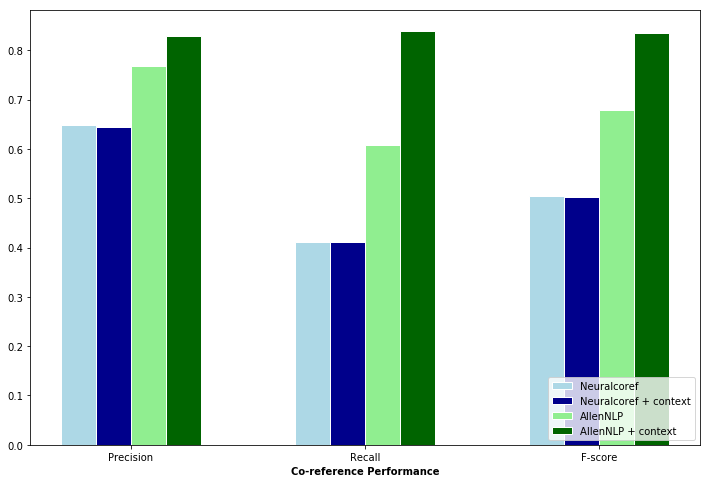

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
plt.rcParams['figure.figsize'] = [12, 8]    

barWidth = 0.15
 
bars1 = [p_neuralcoref, r_neuralcoref, f_neuralcoref]
bars2 = [p_neuralcoref_context, r_neuralcoref_context, f_neuralcoref_context]
bars3 = [p_allennlp, r_allennlp, f_allennlp]
bars4 = [p_allennlp_context, r_allennlp_context, f_allennlp_context]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='lightblue', width=barWidth, edgecolor='white', label='Neuralcoref')
plt.bar(r2, bars2, color='darkblue', width=barWidth, edgecolor='white', label='Neuralcoref + context')
plt.bar(r3, bars3, color='lightgreen', width=barWidth, edgecolor='white', label='AllenNLP')
plt.bar(r4, bars4, color='darkgreen', width=barWidth, edgecolor='white', label='AllenNLP + context')
 
# Add xticks on the middle of the group bars
plt.xlabel('Co-reference Performance', fontweight='bold')
plt.xticks([r + 1.5 * barWidth for r in range(len(bars1))], ['Precision', 'Recall', 'F-score'])
 
# Create legend & Show graphic
plt.legend(loc='lower right')
plt.show()
